In [113]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display

import utils
import utils.data, utils.ML, utils.models

In [2]:
plt.rcParams["figure.figsize"] = [4.3, 3]

device = "mps"
# device = "cpu"

In [3]:
batch_size = 512
print(f"Using batch size = {batch_size}")

dataloaders = utils.data.get_MNIST_data_loaders(batch_size=batch_size)
train_dataloader, val_dataloader, test_dataloader = dataloaders

Using batch size = 512


In [4]:
loss_fn = nn.MSELoss()

# Linear autoencoder (matrix factorization)

In [5]:
class linear_autoencoder(nn.Module):
    
    def __init__(self, latent_dim):
        super(linear_autoencoder, self).__init__()
        
        self.flatten = nn.Flatten()
        self.encoder = nn.Linear(28*28, latent_dim, bias=False)
        self.decoder = nn.Linear(latent_dim, 28*28, bias=False)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape((x.shape[0], 1, 28, 28))
        return x

In [6]:
latent_dim = 32
print(f"Linear autoencoder with latent dim: {latent_dim}")
print(f"Input data compressed by: {100*(1-latent_dim/(28*28)):.3}%")

model = linear_autoencoder(latent_dim)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-6)

Linear autoencoder with latent dim: 32
Input data compressed by: 95.9%


 epoch:  1, training loss: 0.060, validation loss 0.035, validation SNR 5.060
 epoch:  2, training loss: 0.029, validation loss 0.024, validation SNR 6.723
 epoch:  3, training loss: 0.022, validation loss 0.020, validation SNR 7.482
 epoch:  4, training loss: 0.019, validation loss 0.019, validation SNR 7.802
 epoch:  5, training loss: 0.018, validation loss 0.019, validation SNR 7.599
 epoch:  6, training loss: 0.018, validation loss 0.018, validation SNR 8.023
 epoch:  7, training loss: 0.018, validation loss 0.018, validation SNR 8.046
 epoch:  8, training loss: 0.018, validation loss 0.017, validation SNR 8.070
 epoch:  9, training loss: 0.018, validation loss 0.017, validation SNR 8.069
 epoch: 10, training loss: 0.018, validation loss 0.017, validation SNR 8.063

Average time per epoch: 1.546s


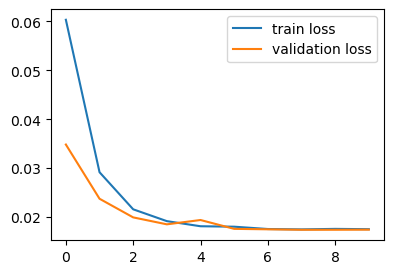

In [7]:
train_loss_log, val_loss_log = utils.ML.train_autoencoder(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs=10, device="cpu", verbose=True)

plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

In [8]:
_, SNR_train = utils.ML.evaluate_autoencoder(model, train_dataloader, loss_fn, "cpu")
_, SNR_test = utils.ML.evaluate_autoencoder(model, test_dataloader, loss_fn, "cpu")
print(f"Train SNR: {SNR_train:.3f} dB")
print(f"Test SNR: {SNR_test:.3f} dB")

Train SNR: 8.073 dB
Test SNR: 8.215 dB


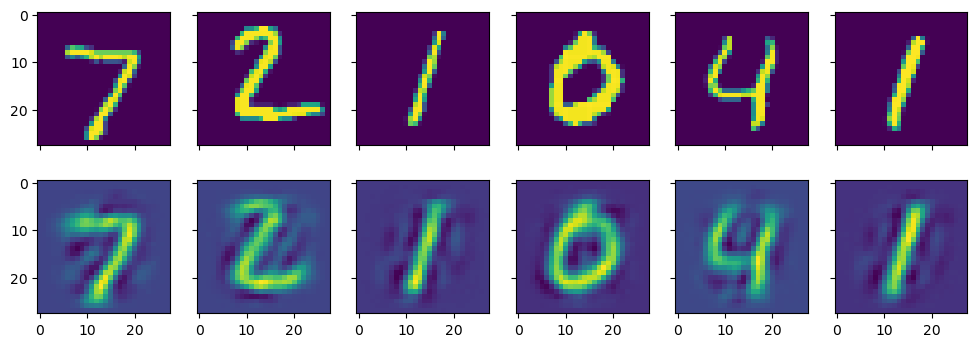

In [9]:
# Let's visualize a few examples:

X, _ = next(iter(test_dataloader))
Y = model(X).detach()

fig, ax = plt.subplots(2, 6, sharey=True, sharex=True, figsize=(12, 4))
for i in range(6):
    ax[0, i].imshow(X[i, 0])  # input
    ax[1, i].imshow(Y[i, 0])  # output

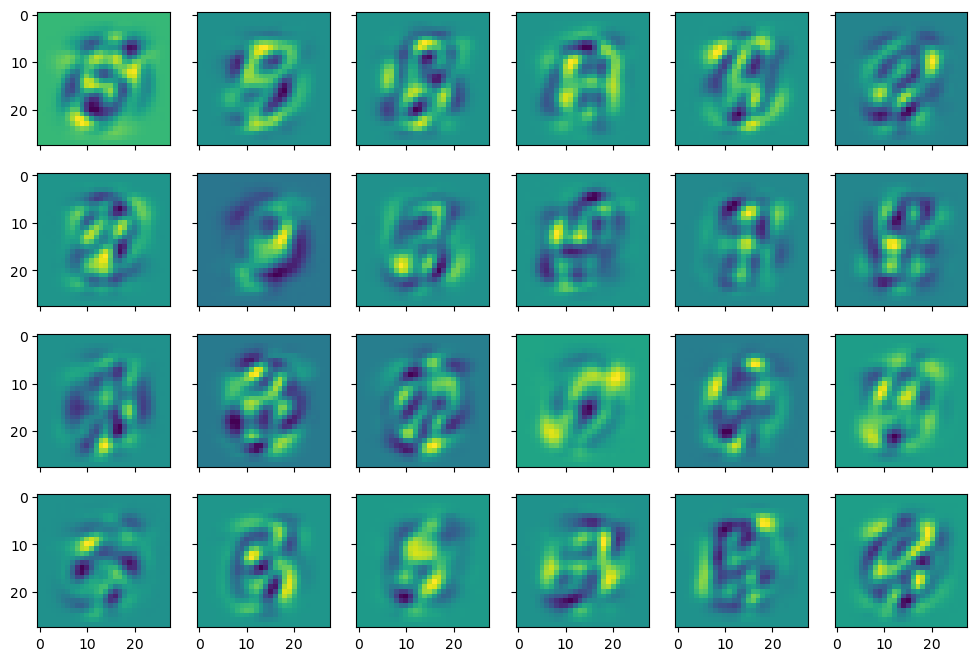

In [10]:
# Plot "principal components":
W = model.decoder.weight

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(12, 8))
ax = ax.flatten()
for i in range(32):
    w = W[:, i].detach().numpy()
    w = w.reshape((28, 28))
    ax[i].imshow(w)

# Fully connected autoencoder:

In [29]:
class FC_autoencoder(nn.Module):
    
    def __init__(self, latent_dim):
        super(FC_autoencoder, self).__init__()
        
        self.flatten = nn.Flatten()
        
        self.encoder = nn.Sequential(nn.Linear(28*28, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, latent_dim))
        
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 28*28),
                                    nn.Sigmoid())
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape((x.shape[0], 1, 28, 28))
        return x

In [30]:
latent_dim = 32

model = FC_autoencoder(latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
num_epochs = 20

 epoch:  1, training loss: 0.071, validation loss 0.045, validation SNR 3.941
 epoch:  2, training loss: 0.037, validation loss 0.030, validation SNR 5.746
 epoch:  3, training loss: 0.025, validation loss 0.021, validation SNR 7.320
 epoch:  4, training loss: 0.018, validation loss 0.016, validation SNR 8.474
 epoch:  5, training loss: 0.014, validation loss 0.013, validation SNR 9.231
 epoch:  6, training loss: 0.012, validation loss 0.012, validation SNR 9.784
 epoch:  7, training loss: 0.011, validation loss 0.011, validation SNR 10.234
 epoch:  8, training loss: 0.010, validation loss 0.010, validation SNR 10.569
 epoch:  9, training loss: 0.009, validation loss 0.009, validation SNR 10.771
 epoch: 10, training loss: 0.009, validation loss 0.009, validation SNR 11.065
 epoch: 11, training loss: 0.008, validation loss 0.008, validation SNR 11.227
 epoch: 12, training loss: 0.008, validation loss 0.008, validation SNR 11.369
 epoch: 13, training loss: 0.008, validation loss 0.008, v

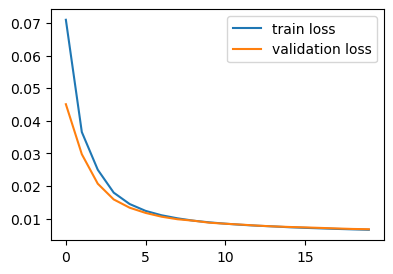

In [31]:
train_loss_log, val_loss_log = utils.ML.train_autoencoder(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

In [32]:
_, SNR_train = utils.ML.evaluate_autoencoder(model, train_dataloader, loss_fn, device)
_, SNR_test = utils.ML.evaluate_autoencoder(model, test_dataloader, loss_fn, device)
print(f"Train SNR: {SNR_train:.3f} dB")
print(f"Test SNR: {SNR_test:.3f} dB")

Train SNR: 12.390 dB
Test SNR: 12.411 dB


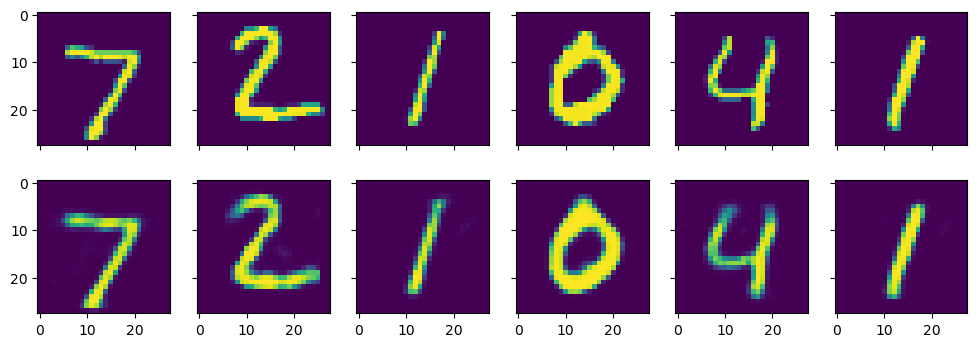

In [33]:
X, _ = next(iter(test_dataloader))
Y = model(X.to(device)).detach().cpu()

fig, ax = plt.subplots(2, 6, sharey=True, sharex=True, figsize=(12, 4))
for i in range(6):
    ax[0, i].imshow(X[i, 0])  # input
    ax[1, i].imshow(Y[i, 0])  # output

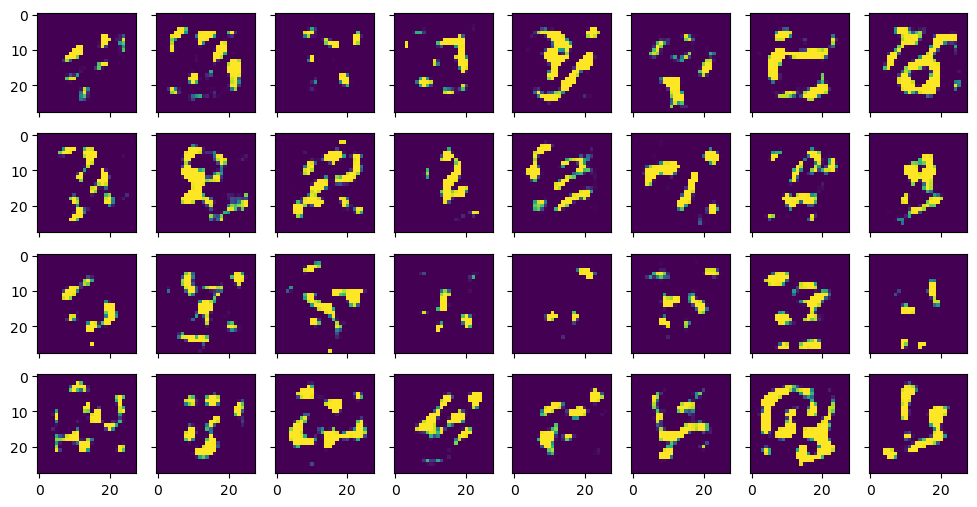

In [34]:
# Plot "principal components":

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(12, 6))
ax = ax.flatten()

for i in range(32):
    x_code = torch.zeros((1, latent_dim))
    x_code[0,i] = 100.0
    x_code = x_code.to(device)
    out = model.decoder(x_code)
    out = out.reshape((1, 1, 28, 28))
    out_im = out[0,0].detach().cpu()
    ax[i].imshow(out_im)

# CNN-based autoencoder:

In [18]:
class CNN_autoencoder(nn.Module):
    
    def __init__(self, latent_dim):
        super(CNN_autoencoder, self).__init__()
                
        self.encoder = nn.Sequential(nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=0),  # 8x26x26
                                    nn.ReLU(),
                                    nn.Conv2d(8, 32, kernel_size=3, stride=2, padding=0),  # 32x12x12
                                    nn.ReLU(),
                                    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=0),  # 64x5x5
                                    nn.ReLU(),
                                    nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=0), # 128x1x1
                                    nn.ReLU(),
                                    nn.Conv2d(128, latent_dim, kernel_size=1, stride=1)  # 1x1 convolution
                                    )
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(latent_dim, 128, kernel_size=1, stride=1),
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(128, 64, kernel_size=5, stride=1, padding=0),  # 64x5x5
                                    nn.ReLU(),
                                    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0, output_padding=1),
                                    nn.ReLU(),  # 32x12x12
                                    nn.ConvTranspose2d(32, 8, kernel_size=3, stride=2, padding=0, output_padding=1),
                                    nn.ReLU(),  # 8x26x26
                                    nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=0),  
                                    nn.Sigmoid()  # 1x28x28
                                    )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [19]:
latent_dim = 32
model = CNN_autoencoder(latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
num_epochs = 20

 epoch:  1, training loss: 0.146, validation loss 0.102, validation SNR 0.412
 epoch:  2, training loss: 0.081, validation loss 0.067, validation SNR 2.223
 epoch:  3, training loss: 0.052, validation loss 0.040, validation SNR 4.447
 epoch:  4, training loss: 0.034, validation loss 0.029, validation SNR 5.903
 epoch:  5, training loss: 0.025, validation loss 0.022, validation SNR 6.963
 epoch:  6, training loss: 0.021, validation loss 0.019, validation SNR 7.671
 epoch:  7, training loss: 0.018, validation loss 0.017, validation SNR 8.098
 epoch:  8, training loss: 0.016, validation loss 0.015, validation SNR 8.671
 epoch:  9, training loss: 0.015, validation loss 0.014, validation SNR 8.923
 epoch: 10, training loss: 0.014, validation loss 0.013, validation SNR 9.224
 epoch: 11, training loss: 0.013, validation loss 0.012, validation SNR 9.524
 epoch: 12, training loss: 0.012, validation loss 0.012, validation SNR 9.815
 epoch: 13, training loss: 0.011, validation loss 0.011, validat

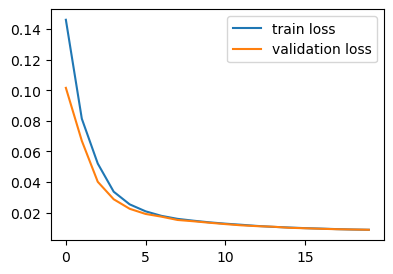

In [20]:
train_loss_log, val_loss_log = utils.ML.train_autoencoder(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

In [21]:
_, SNR_train = utils.ML.evaluate_autoencoder(model, train_dataloader, loss_fn, device)
_, SNR_test = utils.ML.evaluate_autoencoder(model, test_dataloader, loss_fn, device)
print(f"Train SNR: {SNR_train:.3f} dB")
print(f"Test SNR: {SNR_test:.3f} dB")

Train SNR: 11.175 dB
Test SNR: 11.234 dB


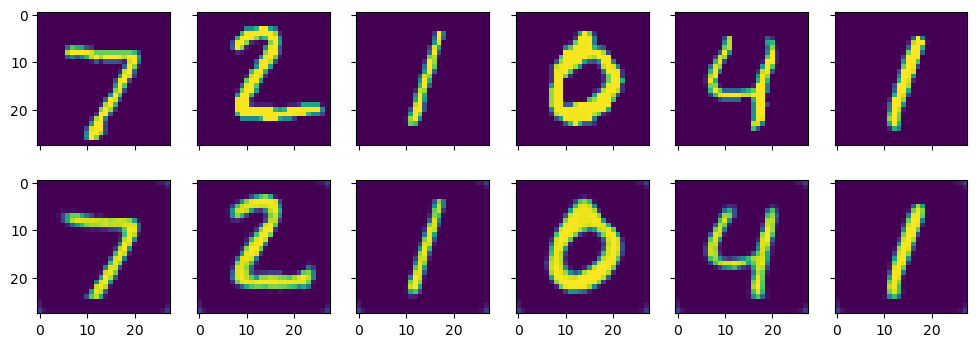

In [22]:
# Visualize a few examples:

X, _ = next(iter(test_dataloader))
Y = model(X.to(device)).detach().cpu()

fig, ax = plt.subplots(2, 6, sharey=True, sharex=True, figsize=(12, 4))
for i in range(6):
    ax[0, i].imshow(X[i, 0])  # input
    ax[1, i].imshow(Y[i, 0])  # output

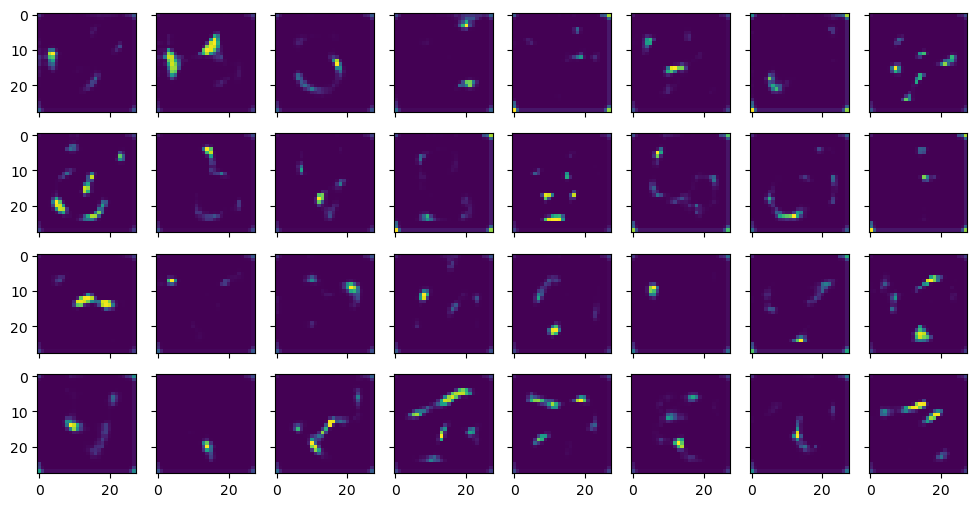

In [28]:
# Plot "principal components":

fig, ax = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(12, 6))
ax = ax.flatten()

for i in range(32):
    x_code = torch.zeros((1, latent_dim, 1, 1))
    x_code[0,i,0,0] = 100.0
    x_code = x_code.to(device)
    out = model.decoder(x_code)
    out_im = out[0,0].detach().cpu()
    ax[i].imshow(out_im)

# Autoencoder with 2-dimensional latent space

In [35]:
latent_dim = 2
model = CNN_autoencoder(latent_dim).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
num_epochs = 50

 epoch:  1, training loss: 0.130, validation loss 0.091, validation SNR 0.875
 epoch:  2, training loss: 0.076, validation loss 0.067, validation SNR 2.228
 epoch:  3, training loss: 0.063, validation loss 0.059, validation SNR 2.802
 epoch:  4, training loss: 0.056, validation loss 0.053, validation SNR 3.203
 epoch:  5, training loss: 0.051, validation loss 0.049, validation SNR 3.563
 epoch:  6, training loss: 0.048, validation loss 0.047, validation SNR 3.797
 epoch:  7, training loss: 0.046, validation loss 0.045, validation SNR 3.952
 epoch:  8, training loss: 0.044, validation loss 0.044, validation SNR 4.047
 epoch:  9, training loss: 0.043, validation loss 0.043, validation SNR 4.149
 epoch: 10, training loss: 0.043, validation loss 0.042, validation SNR 4.213
 epoch: 11, training loss: 0.042, validation loss 0.042, validation SNR 4.245
 epoch: 12, training loss: 0.042, validation loss 0.042, validation SNR 4.289
 epoch: 13, training loss: 0.041, validation loss 0.041, validat

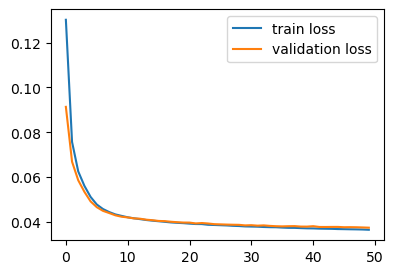

In [36]:
train_loss_log, val_loss_log = utils.ML.train_autoencoder(model, train_dataloader, val_dataloader, optimizer, loss_fn, num_epochs, device, verbose=True)

plt.figure()
plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.legend(["train loss", "validation loss"])

In [37]:
_, SNR_train = utils.ML.evaluate_autoencoder(model, train_dataloader, loss_fn, device)
_, SNR_test = utils.ML.evaluate_autoencoder(model, test_dataloader, loss_fn, device)
print(f"Train SNR: {SNR_train:.3f} dB")
print(f"Test SNR: {SNR_test:.3f} dB")

Train SNR: 4.888 dB
Test SNR: 4.794 dB


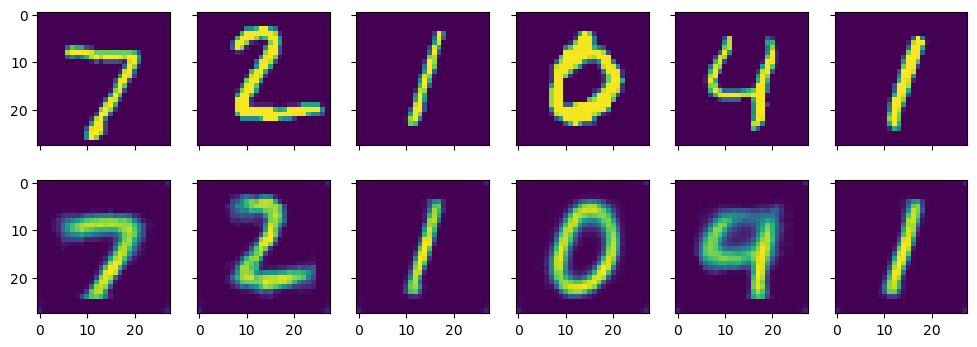

In [38]:
# Visualize a few examples:

X, _ = next(iter(test_dataloader))
Y = model(X.to(device)).detach().cpu()

fig, ax = plt.subplots(2, 6, sharey=True, sharex=True, figsize=(12, 4))
for i in range(6):
    ax[0, i].imshow(X[i, 0])  # input
    ax[1, i].imshow(Y[i, 0])  # output

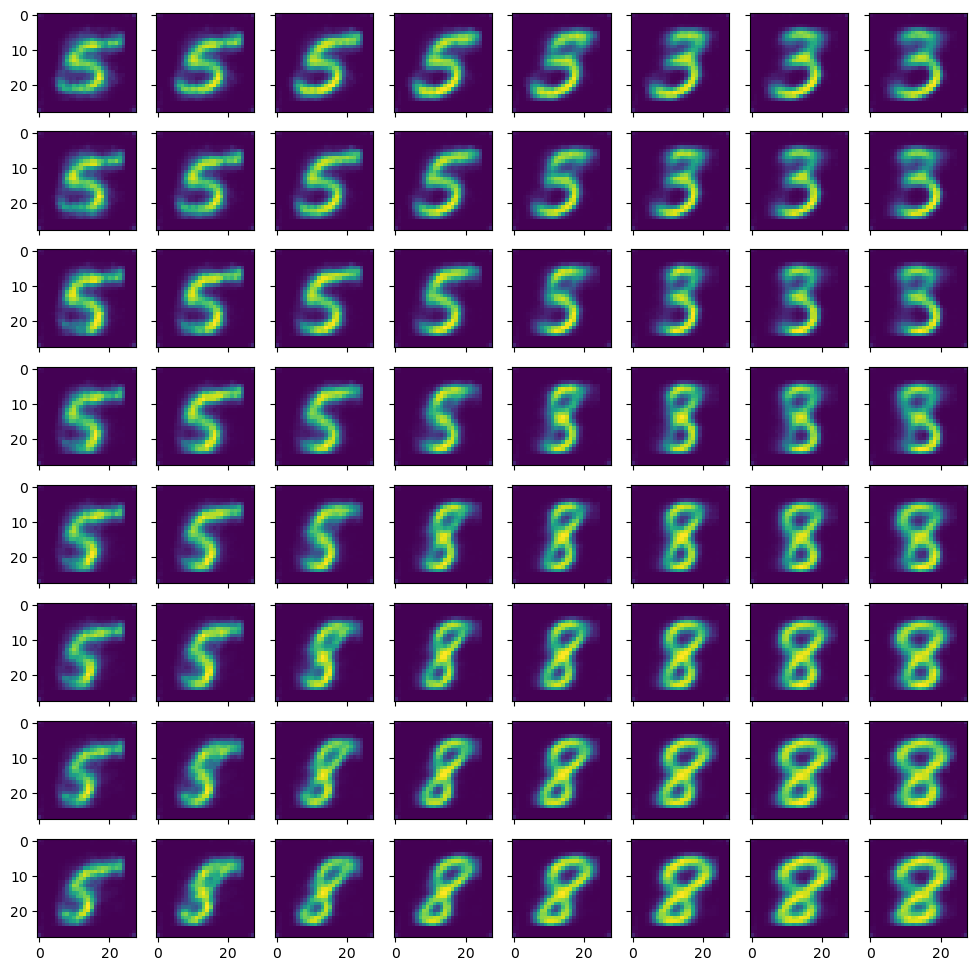

In [127]:
# Plot generated images on a 2D grid:

fig, ax = plt.subplots(8, 8, sharex=True, sharey=True, figsize=(12, 12))

range_ = -2, 2
x_range = np.linspace(range_[0], range_[1], 8)
y_range = np.linspace(range_[0], range_[1], 8)

for i in range(8):
    for j in range(8):
        x_code = torch.zeros((1, latent_dim, 1, 1))
        x_code[0,0,0,0] = x_range[i]
        x_code[0,1,0,0] = y_range[j]
        x_code = x_code.to(device)
        out = model.decoder(x_code)
        out_im = out[0,0].detach().cpu()
        ax[i, j].imshow(out_im)
#         ax[i, j].set_title(f'{x_range[i]:.1f}, {y_range[j]:.1f}')

Text(0.5, 1.0, '2-dimensional encoding of MNIST images')

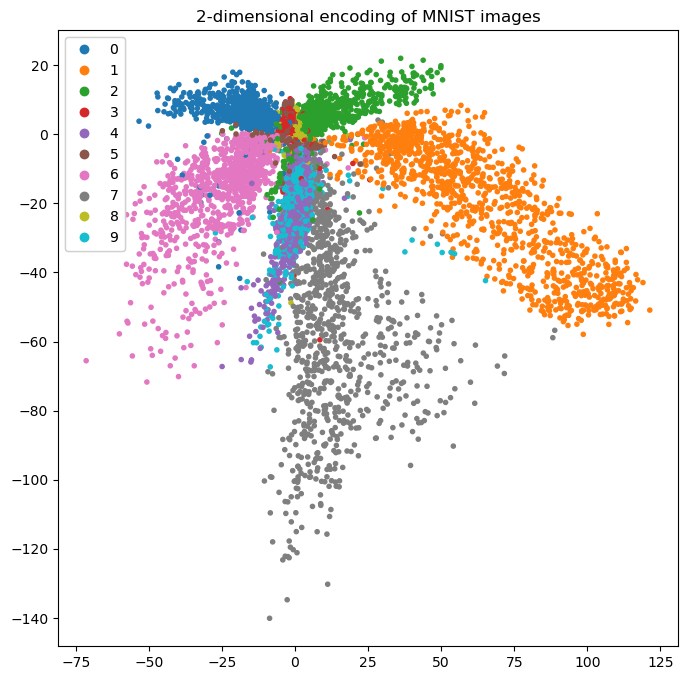

In [123]:
# Plot scatterplot:

fig, ax = plt.subplots(figsize=(8, 8))

for X, y in test_dataloader:
    
    Z = model.encoder(X.to(device))
    Z = Z[..., 0, 0].detach().cpu()
            
    scatter = ax.scatter(Z[:, 0], Z[:, 1], c=y, cmap="tab10", marker=".")
                
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
ax.set_title('2-dimensional encoding of MNIST images')

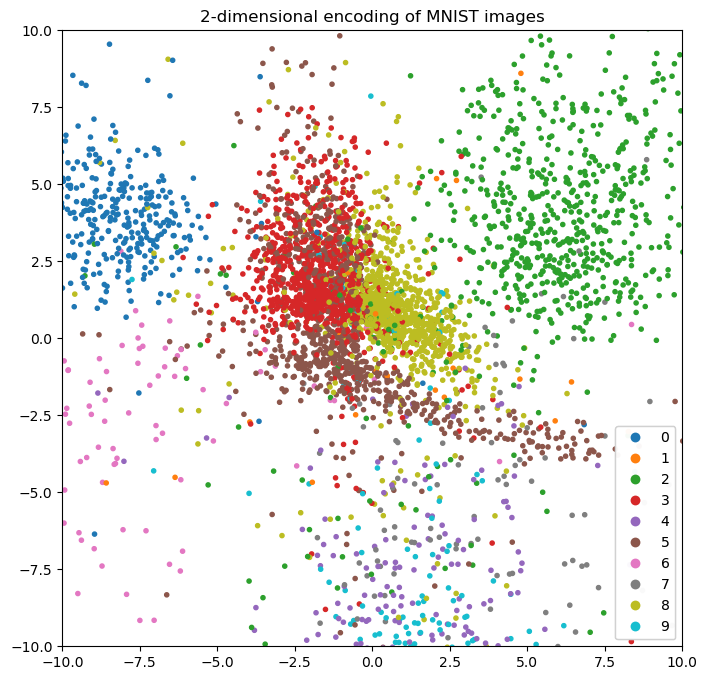

In [125]:
# zoomed-in image:
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
display(fig)